# Libraries needed

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score,classification_report


# Dataset & Preprocessing

In [9]:
# Load the dataset
data = pd.read_csv('placementdata.csv')

# Display the first few rows of the dataset
data.head()


,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


In [10]:
# Count the number of students placed and not placed
placement_counts = data['PlacementStatus'].value_counts()
print("Placement Status Counts:")
print(placement_counts)

Placement Status Counts:
PlacementStatus
NotPlaced    5803
Placed       4197
Name: count, dtype: int64


In [11]:
# Data Preprocessing

# Drop the StudentID column
data.drop(columns=['StudentID'], inplace=True)

# Define Categorical, Numerical Features & Target
categorical_columns = ['ExtracurricularActivities', 'PlacementTraining', 'PlacementStatus']
numerical_columns = [col for col in data.columns if col not in categorical_columns]
target = 'PlacementStatus'

# Encode Categorical Features (Excluding Target)
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Scale Only Numerical Features
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
print("Preprocessed Data:")
print(data.head())

Preprocessed Data:
       CGPA  Internships  Projects  Workshops/Certifications  \
0 -0.309343    -0.073889 -1.182822                 -0.014598   
1  1.877818    -1.575689  1.121526                  1.091319   
2 -0.621794    -0.073889 -0.030648                  1.091319   
3 -0.309343    -0.073889 -1.182822                  1.091319   
4  0.940464    -0.073889 -0.030648                  1.091319   

   AptitudeTestScore  SoftSkillsRating  ExtracurricularActivities  \
0          -1.770910          0.184742                          0   
1           1.292970         -0.787072                          1   
2           0.312528          1.156555                          1   
3           0.680194          0.184742                          1   
4           0.802749          0.427695                          1   

   PlacementTraining  SSC_Marks  HSC_Marks  PlacementStatus  
0                  0  -0.782306   0.504368                0  
1                  1   0.847618   0.840726               

In [13]:
# Remove rows with missing labels (PlacementStatus)
data_clean = data.dropna(subset=['PlacementStatus']).copy()

# Extract features (excluding the target variable)
features = data_clean.iloc[:, :-1]  # Use data_clean, not data

# Apply K-Means Clustering
num_clusters = 2  
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
data_clean['Cluster'] = kmeans.fit_predict(features)  # Assign clusters to data_clean

# Map Clusters to Placement Labels
cluster_map = data_clean.groupby('Cluster')['PlacementStatus'].mean()
placement_mapping = {cluster_map.idxmax(): 1, cluster_map.idxmin(): 0}
data_clean['Predicted_Placement'] = data_clean['Cluster'].map(placement_mapping)

print(data_clean.head())  # Verify output

       CGPA  Internships  Projects  Workshops/Certifications  \
0 -0.309343    -0.073889 -1.182822                 -0.014598   
1  1.877818    -1.575689  1.121526                  1.091319   
2 -0.621794    -0.073889 -0.030648                  1.091319   
3 -0.309343    -0.073889 -1.182822                  1.091319   
4  0.940464    -0.073889 -0.030648                  1.091319   

   AptitudeTestScore  SoftSkillsRating  ExtracurricularActivities  \
0          -1.770910          0.184742                          0   
1           1.292970         -0.787072                          1   
2           0.312528          1.156555                          1   
3           0.680194          0.184742                          1   
4           0.802749          0.427695                          1   

   PlacementTraining  SSC_Marks  HSC_Marks  PlacementStatus  Cluster  \
0                  0  -0.782306   0.504368                0        0   
1                  1   0.847618   0.840726              

C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


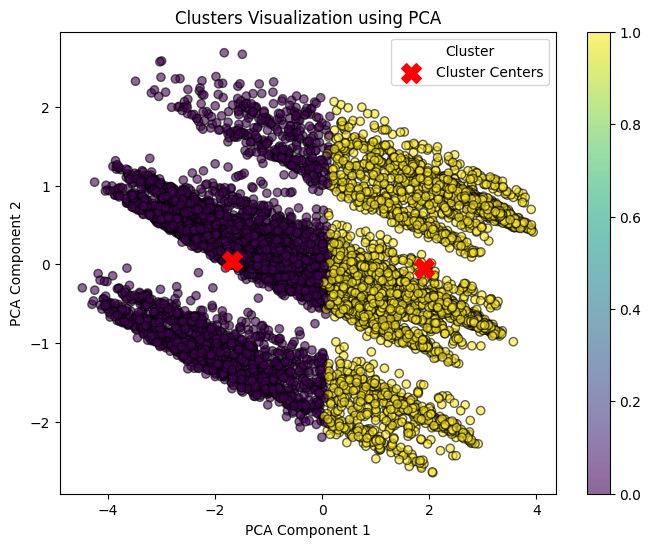

In [14]:
# 🔥 PCA for Cluster Visualization with Center Points
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)  # Only numerical features

# Get cluster centers
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.predict(features), cmap='viridis', alpha=0.6, edgecolor='k')
plt.colorbar()
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', marker='X', s=200, label="Cluster Centers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters Visualization using PCA")
plt.legend(title="Cluster")
plt.show()

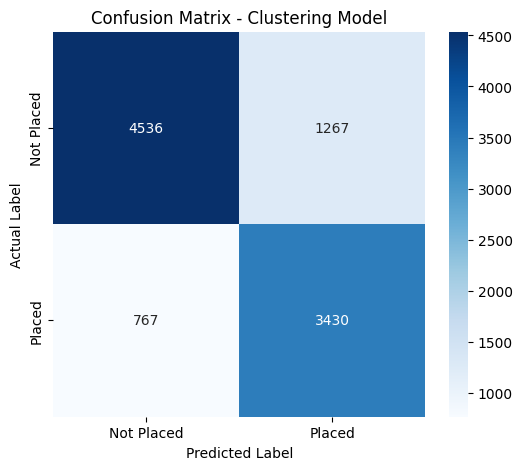

In [16]:
# ✅ Compute Confusion Matrix
y_clean = data_clean['PlacementStatus']
cm = confusion_matrix(y_clean, data_clean['Predicted_Placement'])

# 🔥 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Placed', 'Placed'], yticklabels=['Not Placed', 'Placed'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Clustering Model")
plt.show()

In [17]:
# 🔥 Compute Evaluation Metrics
accuracy = accuracy_score(y_clean, data_clean['Predicted_Placement'])
precision = precision_score(y_clean, data_clean['Predicted_Placement'])
recall = recall_score(y_clean, data_clean['Predicted_Placement'])
f1 = f1_score(y_clean, data_clean['Predicted_Placement'])

# ✅ Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7966
Precision: 0.7303
Recall: 0.8173
F1-Score: 0.7713
